In [19]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
import scipy.cluster.hierarchy as hc
from itertools import zip_longest
import pickle

In [2]:
sns.set_context("talk")
sns.set_palette("colorblind")

In [3]:
def fetch_bibliography(author, limit=1000):
    # this is the function used to fetch the expert's bibliography from SemanticScholar
    fields = ",".join(["fieldsOfStudy", "s2FieldsOfStudy", "abstract", "year", "title"])
    params = {"limit": limit, "fields": fields}
    url = "https://api.semanticscholar.org/graph/v1/author/{}/papers".format(author)

    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise Exception(resp.reason)
    literature = resp.json()
    if len(literature["data"]) == limit:
        print(author, "=> result set may be partial!")
    return literature

def parse_fields_of_study(paper):
    fos = []
    if ("s2FieldsOfStudy" in paper) and (paper["s2FieldsOfStudy"] is not None):
        for field in paper["s2FieldsOfStudy"]:
            fos.append(field["category"].replace(" ", "_"))
    if ("fieldsOfStudy" in paper) and (paper["fieldsOfStudy"] is not None):
        fos.extend([s.replace(" ", "_") for s in paper["fieldsOfStudy"]])
    return set(fos)

# Collect bibliographies

In [5]:
with open('../data/expert_bibliographies_anon.pickle', 'rb') as handle:
    bibs = pickle.load(handle)

In [6]:
for author, papers in bibs.items():
    print(author, len(papers["data"]))

expert_01 327
expert_02 81
expert_03 329
expert_04 143
expert_05 588
expert_07 343
expert_08 126
expert_09 77
expert_10 414
expert_11 115
expert_06 127
expert_12 271
expert_13 53
expert_14 91
expert_15 501
expert_16 190
expert_17 22


# Compute bag-of-words for each paper

In [7]:
papers = {}
for bibliography in bibs.values():
    for paper in bibliography["data"]:
        # we need to transform the list of fields in a string to be properly processed by sklearn
        papers[paper["paperId"]] = ",".join(parse_fields_of_study(paper))

In [10]:
cvect = CountVectorizer().fit(papers.values())
bow = pd.DataFrame.from_dict(
    {k:cvect.transform([v]).toarray().squeeze() for k,v in papers.items()}, 
    columns=[x[0] for x in sorted(cvect.vocabulary_.items(), key=lambda x: x[1])],
    orient="index", 
)
tfidf = pd.DataFrame(TfidfTransformer().fit_transform(bow).toarray(), index=bow.index, columns=bow.columns)
tfidf = tfidf.rename(columns={
    "chemistry": "chem",
    "biology": "bio",
    "computer_science": "compsci",
    "physics": "phys",
    "medicine":"med",
    "engineering": "eng",
    "environmental_science": "envsci",
    "geology": "geo",
    "psychology": "psy",
    "materials_science": "matsci"
})
tfidf

,agricultural_and_food_sciences,art,bio,business,chem,compsci,economics,education,eng,envsci,...,law,linguistics,matsci,mathematics,med,philosophy,phys,political_science,psy,sociology
paper0,0.0,0.0,0.737856,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.555919,...,0.0,0.0,0.000000,0.0,0.382783,0.0,0.0,0.0,0.0,0.0
paper1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.823635,...,0.0,0.0,0.000000,0.0,0.567121,0.0,0.0,0.0,0.0,0.0
paper2,0.0,0.0,0.284477,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.214332,...,0.0,0.0,0.000000,0.0,0.147580,0.0,0.0,0.0,0.0,0.0
paper3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.638566,...,0.0,0.0,0.631590,0.0,0.439690,0.0,0.0,0.0,0.0,0.0
paper4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.653536,0.483327,...,0.0,0.0,0.478048,0.0,0.332799,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
paper3601,0.0,0.0,0.000000,0.0,0.433923,0.858015,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.274812,0.0,0.0,0.0,0.0,0.0
paper3602,0.0,0.0,0.000000,0.0,0.433923,0.858015,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.274812,0.0,0.0,0.0,0.0,0.0
paper3603,0.0,0.0,0.000000,0.0,0.433923,0.858015,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.274812,0.0,0.0,0.0,0.0,0.0
paper3604,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [12]:
nmf = NMF(n_components=6).fit(tfidf.values)
loadings = pd.DataFrame(nmf.components_, columns=tfidf.columns)
weights = pd.DataFrame(nmf.transform(tfidf.values), index=tfidf.index)

topics = {}
for author in bibs:
    p = [x["paperId"] for x in bibs[author]["data"]]
    df = weights.loc[p].apply(lambda x: x/np.linalg.norm(x), axis=1)
    topics[author] = (np.sum(df, axis=0) / df.shape[0])

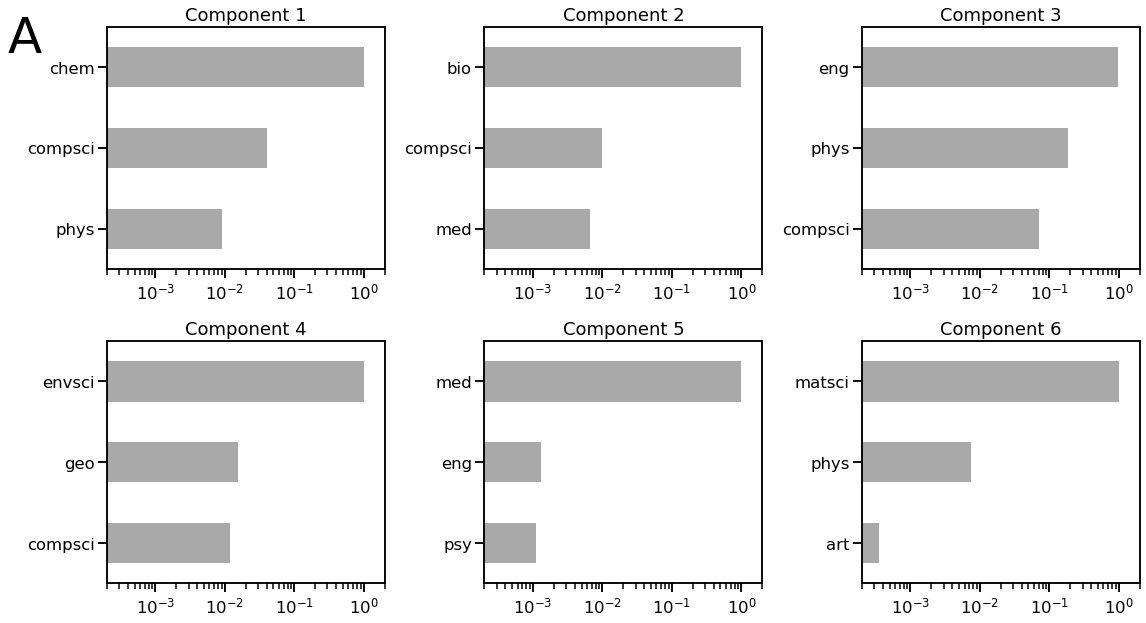

In [13]:
# Figure 1 - Panel A
xlim = (1e-4+0.0001, 1e0 + 1)
fig1A, axes = plt.subplots(2, 3, figsize=(16, 9))
for i, ax in zip(range(loadings.shape[0]), axes.ravel()):
    l = loadings.loc[i, :]
    norm = np.linalg.norm(l)
    (l/norm).sort_values()[-3:].plot(kind="barh", ax=ax, title="Component {}".format(i+1), color="darkgray")
    ax.set_xscale("log")
    ax.set_xlim(xlim)
fig1A.text(0, 0.90, 'A', fontsize=50, transform=fig1A.transFigure)
fig1A.tight_layout()

# Expert clustering based on scientific topics

In [17]:
df2 = pd.DataFrame.from_dict(topics, orient="columns")
l = hc.linkage(df2.T, method="ward")
column_clusters = hc.fcluster(l, t=0.5, criterion='distance')

cmap = sns.color_palette("husl", np.max(column_clusters))
author_ids = {a:n for n, a in enumerate(topics)}

In [16]:
sorted_authors = [
    'expert_04',
    'expert_06',
    'expert_17',
    'expert_05',
    'expert_10',
    'expert_14',
    'expert_07',
    'expert_08',
    'expert_12',
    'expert_03',
    'expert_13',
    'expert_16',
    'expert_01',
    'expert_02',
    'expert_09',
    'expert_11',
    'expert_15'
]

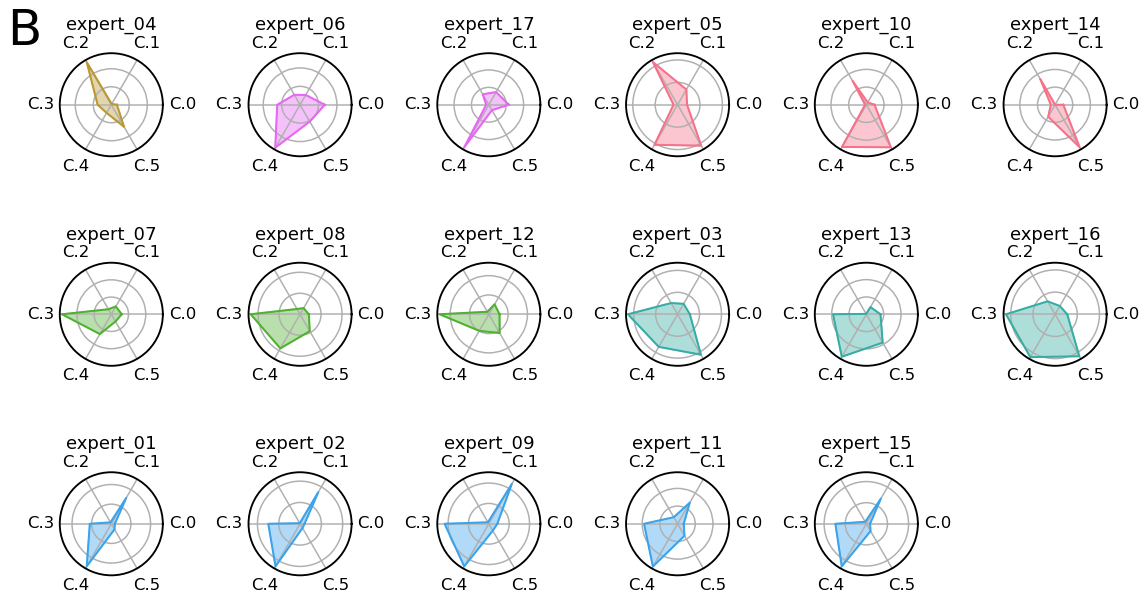

In [18]:
fig1B, axes = plt.subplots(3, 6, figsize=(16, 9), subplot_kw=dict(polar=True))

for author, ax in zip_longest(sorted_authors, axes.ravel(), fillvalue=None):
    if author == None:
        ax.set_axis_off()
        continue
    categories = ["C.{}".format(i) for i in range(6)]
    values = topics[author].to_list()
    num_categories = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    angles += angles[:1]
    values += values[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', markersize=8, color=cmap[column_clusters[author_ids[author]]-1])
    ax.fill(angles, values, alpha=0.4, color=cmap[column_clusters[author_ids[author]]-1])

    # Set the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])
    ax.set_title(author)

fig1B.text(0, 0.90, 'B', fontsize=50, transform=fig1B.transFigure)
fig1B.tight_layout()

In [20]:
# !convert "fig1A.png" "fig1B.png" -gravity center -append "fig1.png"